In [3]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from wordcloud import WordCloud
from collections import Counter

import torch
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, AdamW, get_scheduler
from pytorch_optimizer import RAdam

In [4]:
import warnings
warnings.filterwarnings('ignore')


In [6]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

df.columns = ['target', 'id', 'date', 'query', 'user', 'text']

df = df[['target', 'text']]

df_first_1000 = df.head(1000)

df_after_800k = df.iloc[800000:801000]

df_combined = pd.concat([df_first_1000, df_after_800k])

df_combined = df_combined.reset_index(drop=True)


df_combined.to_csv('/kaggle/working/combined_sentiment140.csv', index=False)

print(df_combined.head())
print(df_combined.tail())

   target                                               text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....
      target                                               text
1995       4  I have this strange desire to go to confession...
1996       4             @i_reporter answer sent in dm. try it 
1997       4  @brooklynunion cuz ur 3pm is my 9am and Id be ...
1998       4  @littrellfans Its all good. Just figured you w...
1999       4                   @nicolerichie Yea I remember it 


In [7]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text) 
    text = text.lower()
    return text

df['clean_text'] = df['text'].apply(clean_text)

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str): 
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_tokens)
    else:
        return ''  

df['clean_text'] = df['clean_text'].apply(remove_stopwords)

df.head()


,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",thats bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


In [8]:


negative_texts = df['clean_text'][:50].dropna().astype(str)  
positive_texts = df['clean_text'][1000:1000+50].dropna().astype(str)  

positive_words = ' '.join(positive_texts).split()
negative_words = ' '.join(negative_texts).split()

positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

print("Top 10 most common words in positive sentences:")
print(positive_word_freq.most_common(10))

print("Top 10 most common words in negative sentences:")
print(negative_word_freq.most_common(10))


Top 10 most common words in positive sentences:
[('im', 10), ('cant', 7), ('got', 6), ('good', 5), ('pretty', 4), ('like', 4), ('dont', 3), ('didnt', 3), ('video', 3), ('much', 3)]
Top 10 most common words in negative sentences:
[('im', 7), ('sad', 7), ('like', 5), ('time', 5), ('day', 4), ('see', 4), ('didnt', 4), ('one', 4), ('dont', 4), ('got', 3)]


Number of positive words: 275
Number of negative words: 272


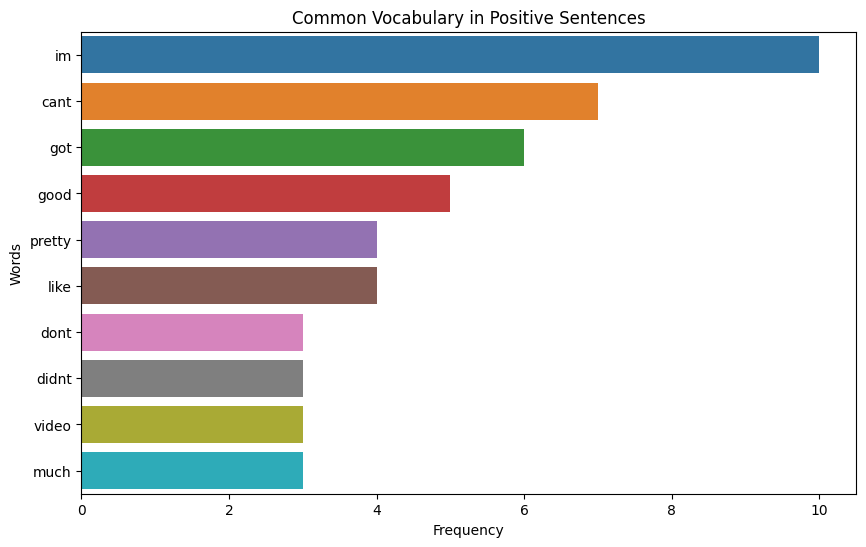

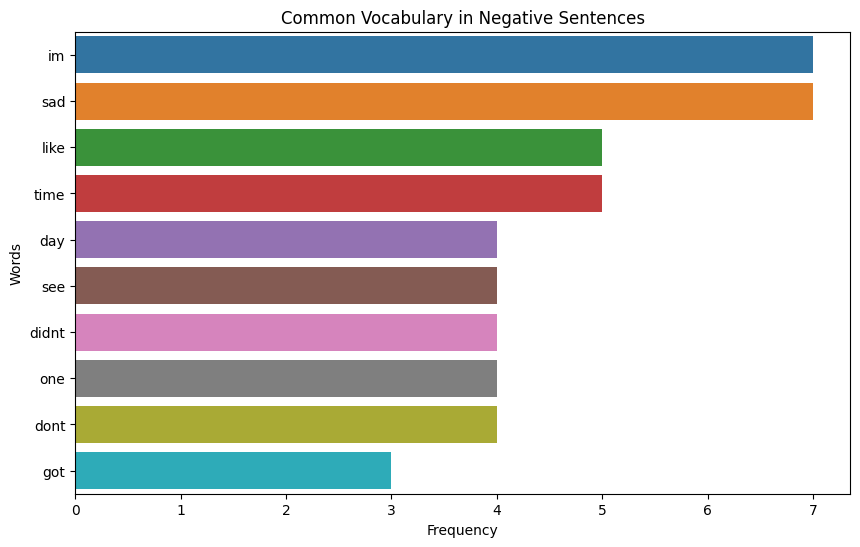

In [10]:
def plot_word_frequency(word_freq, title):
    common_words = word_freq.most_common(10)
    if not common_words:  
        print("No words to display.")
        return

    words = [word for word, freq in common_words]
    freqs = [freq for word, freq in common_words]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=freqs, y=words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

print("Number of positive words:", len(positive_word_freq))
print("Number of negative words:", len(negative_word_freq))

plot_word_frequency(positive_word_freq, 'Common Vocabulary in Positive Sentences')

plot_word_frequency(negative_word_freq, 'Common Vocabulary in Negative Sentences')


In [ ]:
# !pip install transformers
# !pip install datasets

In [13]:
df['target'] = df['target'].replace(4, 1)

label_counts = df['target'].value_counts()

print("Number of positive and negative data points:")
print(label_counts)

positive_count = label_counts[1]  
negative_count = label_counts[0]  

print(f"Number of positive data points: {positive_count}")
print(f"Number of negative data points: {negative_count}")


Unique labels in dataset: {0, 1}
Number of positive and negative data points:
target
0    800000
1    800000
Name: count, dtype: int64
Number of positive data points: 800000
Number of negative data points: 800000


In [14]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'].tolist(),
    df['target'].tolist(),
    test_size=0.2,
    random_state=42
)


In [15]:
# Load the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=250)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=250)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Convert to tensor format
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [17]:
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
# !pip install pytorch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.0 MB/s eta 0:00:00


In [33]:


print(torch.cuda.is_available())  
print(torch.cuda.device_count())  

training_args = TrainingArguments(
    report_to="none",                     
    num_train_epochs=3,                   
    per_device_train_batch_size=64,        
    warmup_steps=50,                     
    logging_dir='./logs',                 
    learning_rate=1e-5,                   
    adam_beta1=0.9,                       
    adam_epsilon=1e-8,                    
    logging_steps=100,                      
    evaluation_strategy="steps",           
    save_steps=2000,                       
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy",            
)

callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

optimizer = Adam([
    {'params': model.bert.encoder.layer[:6].parameters(), 'lr': 5e-5},
    {'params': model.bert.encoder.layer[6:9].parameters(), 'lr': 3e-5},
    {'params': model.bert.encoder.layer[9:].parameters(), 'lr': 2e-5},
    {'params': model.classifier.parameters(), 'lr': 2e-5}
], betas=(0.9, 0.999), weight_decay=0.001)



# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,          
    eval_dataset=test_dataset,  
    compute_metrics=compute_metrics,
    callbacks=callbacks,                  
    optimizers=(optimizer)  
)


True
2


In [34]:
trainer.train()

predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

comparison_df = pd.DataFrame({
    'Original_Text': test_texts,           
    'Original_Label': test_labels,         
    'Predicted_Label': predictions          
})

print(comparison_df.head(20))

comparison_df.to_csv('bert_comparison_results.csv', index=False)

print(classification_report(test_labels, predictions))

trainer.save_model("./best_model")


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
2000,0.268900,0.473229,0.801063,0.800918,0.802085,0.801063
4000,0.307200,0.453801,0.796669,0.796408,0.798389,0.796669
6000,0.411900,0.410535,0.813969,0.813952,0.814040,0.813969
8000,0.411400,0.401085,0.816063,0.816008,0.816537,0.816063
10000,0.403700,0.394789,0.819581,0.819580,0.819584,0.819581


                                        Original_Text  Original_Label  \
0                                        ahhh hope ok               0   
1                                cool tweet apps razr               0   
2   know family drama lamehey next time u hang kim...               0   
3   school email wont open geography stuff revise ...               0   
4                               upper airways problem               0   
5                     going miss pastors sermon faith               0   
6                                    lunchdj come eat               1   
7                                     oh feeling like               0   
8              gahh noopeyton needs livethis horrible               0   
9   thank glad like product review bit site enjoy ...               1   
10            zach makes pee sitting im grown gay man               1   
11                          sum day one word kackered               1   
12                            great minds think ali

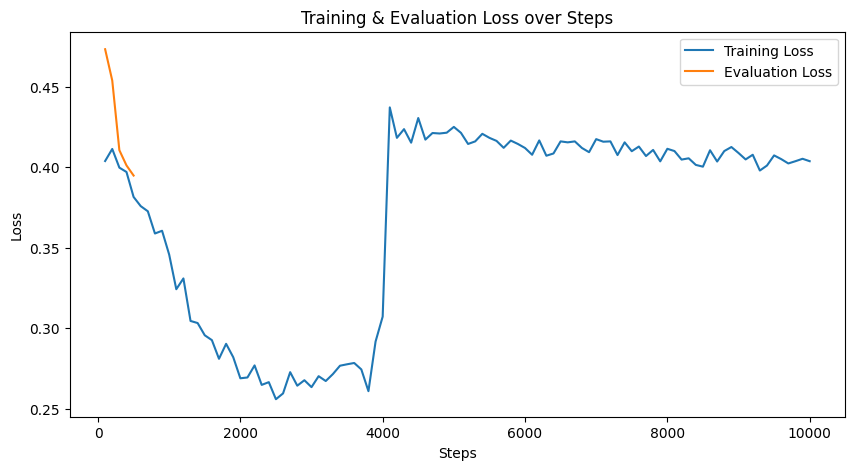

In [35]:
import matplotlib.pyplot as plt

train_loss = []
eval_loss = []
steps = [] 

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
        steps.append(log['step']) 
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Plot Loss over Steps (instead of Epochs)
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Evaluation Loss')  
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training & Evaluation Loss over Steps')
plt.legend()
plt.show()


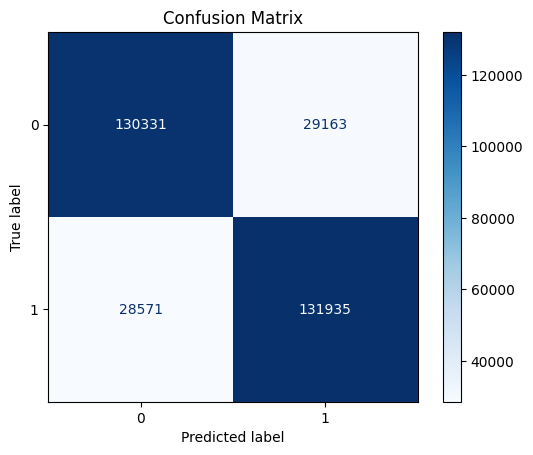

Accuracy: 0.8196
Precision: 0.8196
Recall: 0.8196
F1 Score: 0.8196
AUC-ROC: 0.8196


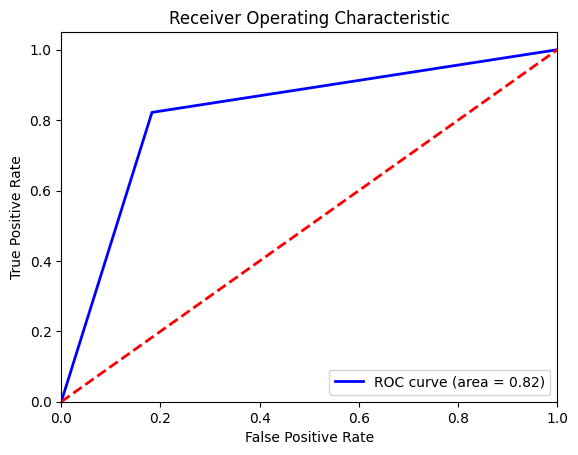

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(test_labels, predictions)
print(f"AUC-ROC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, predictions)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
